<a href="https://colab.research.google.com/github/henriquesluizfernando/datascience/blob/main/Detec%C3%A7%C3%A3o_fraude_cartaodecredito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

O pagamento em cartão traz muitos benefícios, como por exemplo a praticidade, não ter que andar com dinheiro vivo e mais segurança. No entanto, também há seus problemas, como a fraude de cartão de crédito. [A clonagem de cartão de crédito é a fraude mais praticada nos dias atuais](https://noticias.r7.com/economia/fraudes-com-cartao-disparam-na-pandemia-veja-como-se-prevenir-19062020).

Durante a pandemia, as compras por comércio eletrônico aumentaram muito, e junto com elas, as fraudes de cartões de crédito.

<p align=center>
<img src="https://www.infovarejo.com.br/novo/wp-content/uploads/2018/06/7-tipos-de-fraude-740x360.png" width="80%"></p>

Para que nao ocorra maiores problemas em relação a fraudes, bancos e empresas emissoras de cartão buscam se aperfeiçoar para evitar as transações fraudulentas. Uma questão importante a se considerar é que a péssima experiência de um consumidor, que tenta fazer uma compra, e erradamente essa compra é considerada fraude e então bloqueada.

Diante desse cenário, a utilização de inteligência artifical para prever essas situações vem sendo cada vez mais necessário. 

Esse projeto tem como objetivo analisar uma base de dados disponibilzada por empresas européias de cartão de crédito e criar um modelo para detectar as fraudes.

# Obtenção de Dados

Os dados são de transações financeiras ocorridas na europa durante 2 dias, disponibilizados por empresas de cartão de crédito, onde em quase 290 mil transações, 492 foram fraudulentas.

O nome das colunas foi descaracterizado e são representados por $[V1, V2, V3 \dots,V28 ]$. 

As informações da base de dados estão disponíveis [nesse link](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [29]:
# pacotes necessários

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
sns.set_style('dark')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalando scikit-plot
!pip install -q scikit-plot
import scikitplot as skplt

# base de dados
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)


# Análise Exploratória

Aqui será analisado como a base de dados está disposta. Seu tamanho, tipos das variáveis, dados ausentes, observar se a variável alvo está balanceada e também possíveis correções.

A variável alvo é a ```class``` e seus respectivos valores são:

* 0 - Transação normal
* 1 - Fraude

In [2]:
# primeiras entradas

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# quantas observações

print(f'Essa base de dados possui {df.shape[0]} entradas e {df.shape[1]} colunas')

Essa base de dados possui 284807 entradas e 31 colunas


In [8]:
# tipos das variáveis

print(df.dtypes)
print('\nObserva-se que todas as colunas são numéricas')

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Observa-se que todas as colunas são numéricas


In [10]:
# porcentagem de dados faltantes

(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

Class     0.0
V14       0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V15       0.0
Amount    0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Time      0.0
dtype: float64

Número de transações fraudulentas: 492. Representa 0.1727485630620034% do total.
Número de transações normais: 284315. Representa 99.82725143693798% do total.


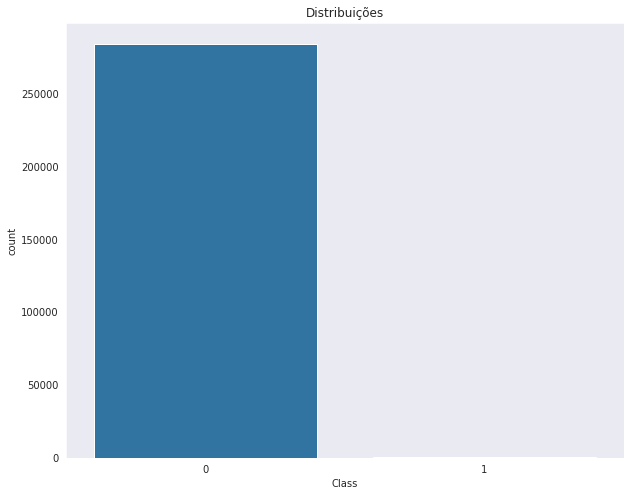

In [33]:
# comparação entre número de transações normais e fraudulentas

print(f'Número de transações fraudulentas: {df.loc[df.Class == 1].shape[0]}. Representa {df.loc[df.Class == 1].shape[0]/df.shape[0]*100}% do total.')
print(f'Número de transações normais: {df.loc[df.Class == 0].shape[0]}. Representa {df.loc[df.Class == 0].shape[0]/df.shape[0]*100}% do total.')

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(df.Class, ax=ax)
ax.set_title('Distribuições')
plt.show()


Observa-se que a proporção entre transações normais e transações fraudulentas está bem desbalanceada, podendo interferir no resultado do modelo de machine learning. É necessário ajustar esse balanceamento.

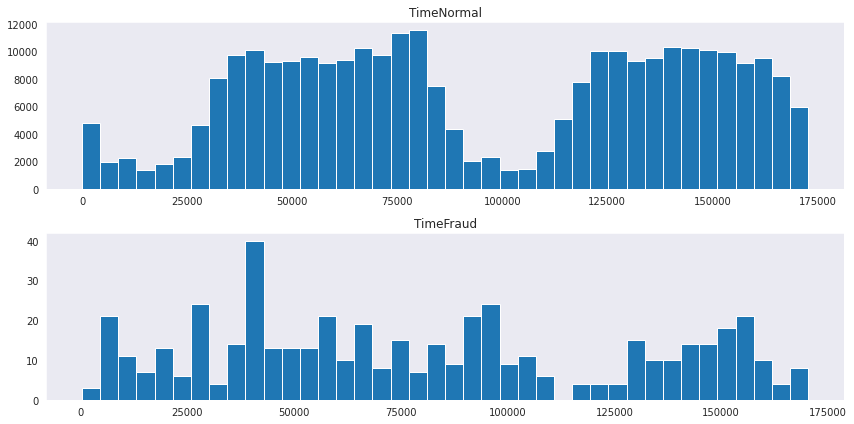

In [39]:
# comparação do tempo

for col in df.columns:
  if col == 'Time':
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

    num_bins = 40

    ax[0].hist(df[col][df.Class == 0], bins=num_bins)
    ax[0].set_title(col + 'Normal')

    ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
    ax[1].set_title(col + 'Fraud')

    plt.tight_layout()

Não se observa grande diferença no tempo em relação aos dois tipos de transação.

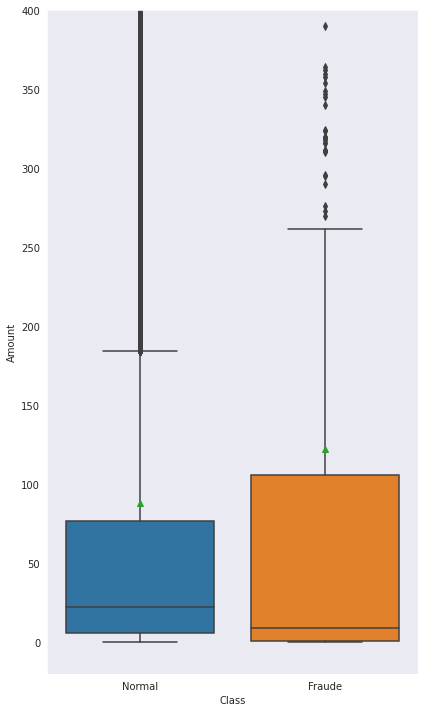

In [42]:
# comparação de quantia
fig, ax = plt.subplots(figsize=(6,10), sharex=True)
sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim(-20,400)
plt.xticks([0,1], ['Normal', 'Fraude'])
plt.tight_layout()

# Preparação dos dados

Como observado, os dados estão desbalanceados e será necessário fazer esse balanceamento. Os dados serão separados em dados de treino e dados de teste e serão padronizados.

In [60]:
# padronizando colunas time e amount

df_clean = df.copy()
df_clean['Amount_pad'] = StandardScaler().fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['Time_pad'] = StandardScaler().fit_transform(df_clean['Time'].values.reshape(-1,1))

# excluindo colunas não padronizadas
df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

df_clean.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_pad,Time_pad
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [63]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

1    369
0    369
dtype: int64


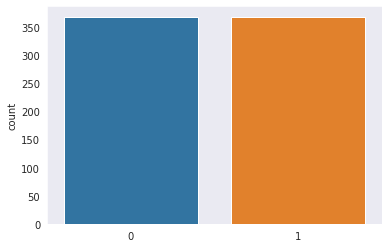

In [64]:
# balanceando

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

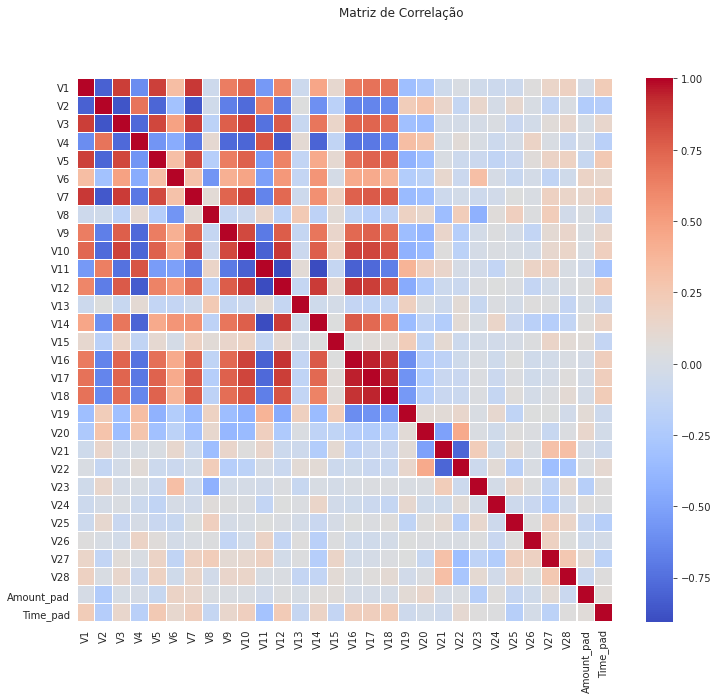

In [70]:
# matriz de correlação

corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(figsize = (12,10))
fig.suptitle('Matriz de Correlação')


sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax)


plt.show()


Feita a matriz de correlação após balanceamento dos dados, verifica-se que algumas features possuem forte correlação, como V17 e V18, por exemplo.

# Modelo de Machine Learning

Com os dados já tratados e prontos, agora é só preparar um modelo para ser treinado e validado

In [72]:
# regressão logística

np.random.seed(2)
lr = LogisticRegression()
lr.fit(X_rus, y_rus)

# previsões

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9713    0.9854     71079
           1     0.0520    0.9106    0.0985       123

    accuracy                         0.9712     71202
   macro avg     0.5259    0.9409    0.5419     71202
weighted avg     0.9982    0.9712    0.9838     71202

Acurácia: 0.9712

AUC: 0.9409



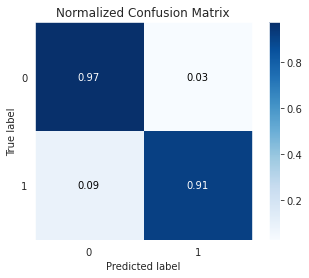

In [73]:
# matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))